In [1]:
# Standard Python libraries
import os                                    # For accessing operating system functionalities
import json                                  # For encoding and decoding JSON data
import pickle                                # For serializing and de-serializing Python objects

# Libraries that can be pip installed
import requests                              # Simple Python library for HTTP
import pandas as pd                          # Library for building dataframes similar to those in R
import seaborn as sns                        # Statistical visualization library based on Matplotlib
import matplotlib.pyplot as plt              # MATLAB-like plotting, useful for interactive viz

# Utilities needed from Scikit-Learn, a robust, comprehensive machine learning library in Python.
# We'll discuss each of these in detail as we come to them in the tutorial.
from sklearn.pipeline import Pipeline
from sklearn.datasets.base import Bunch
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
CENSUS_DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

def download_data(path='data', urls=CENSUS_DATASET):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb') as f:
            f.write(response.content)

download_data()

In [5]:
names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]
# Note: We use a regex trick here for the separator below because the test data
# have a period appended to the end of the class names.
data = pd.read_csv('data/adult.data', sep="\s*,", names=names)
data.head()

/Users/adammorris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


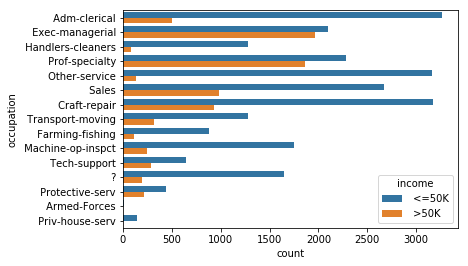

In [9]:
#visual feature analysis
sns.countplot(y='occupation', hue='income', data=data,)
plt.show()

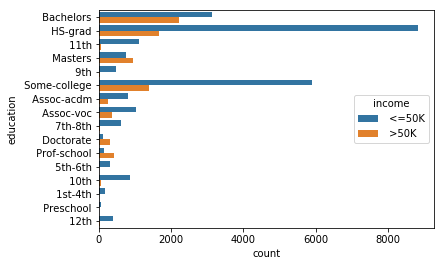

In [10]:
sns.countplot(y='education', hue='income', data=data,)
plt.show()

/Users/adammorris/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


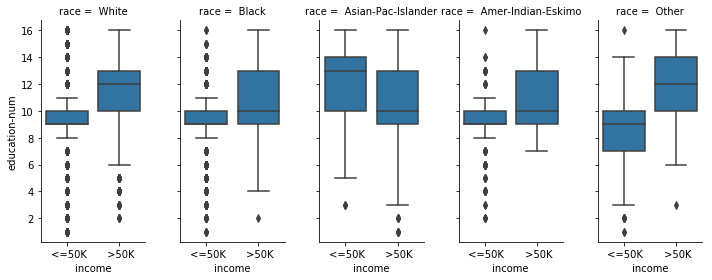

In [12]:
g = sns.FacetGrid(data, col='race', height=4, aspect=.5)
g = g.map(sns.boxplot, 'income', 'education-num')
plt.show()

/Users/adammorris/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/adammorris/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


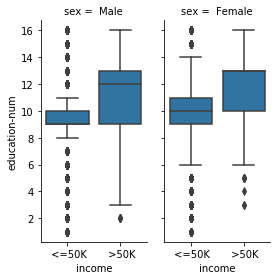

In [13]:
g = sns.FacetGrid(data, col='sex', size=4, aspect=.5)
g = g.map(sns.boxplot, 'income', 'education-num')
plt.show()

/Users/adammorris/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


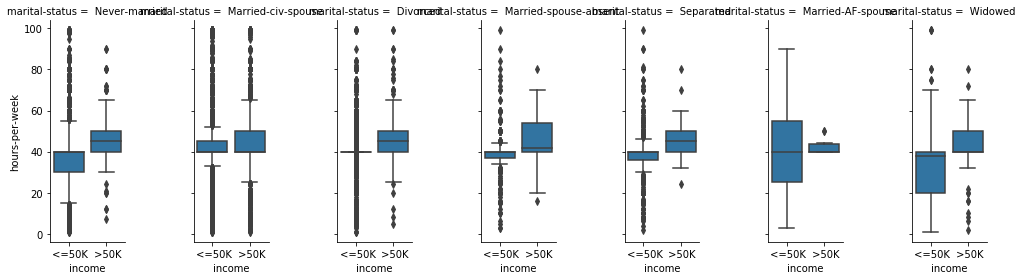

In [16]:
g = sns.FacetGrid(data, col='marital-status', height=4, aspect=.5)
g = g.map(sns.boxplot, 'income', 'hours-per-week')
plt.show()

/Users/adammorris/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


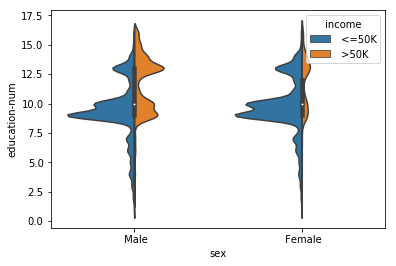

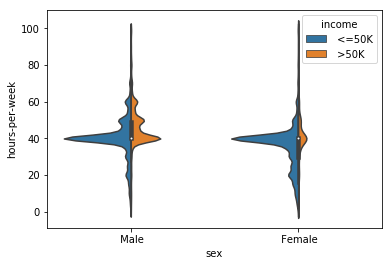

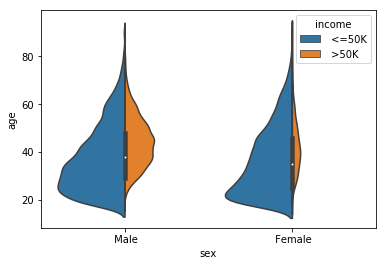

In [20]:
#the white dot represents the median
#the thick gray bar in the center represents the interquartile range
#the thin gray line represents the 95% confidence interval
sns.violinplot(x='sex', y='education-num', hue='income', data=data, split=True, scale='count')
plt.show()

sns.violinplot(x='sex', y='hours-per-week', hue='income', data=data, split=True, scale='count')
plt.show()

sns.violinplot(x='sex', y='age', hue='income', data=data, split=True, scale='count')
plt.show()

In [21]:
import json


meta = {
    'target_names': list(data.income.unique()),
    'feature_names': list(data.columns),
    'categorical_features': {
        column: list(data[column].unique())
        for column in data.columns
        if data[column].dtype == 'object'
    },
}

with open('data/meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

In [22]:
from sklearn.datasets.base import Bunch

def load_data(root='data'):
    # Load the meta data from the file
    with open(os.path.join(root, 'meta.json'), 'r') as f:
        meta = json.load(f)

    names = meta['feature_names']

    # Load the readme information
    with open(os.path.join(root, 'README.md'), 'r') as f:
        readme = f.read()

    # Load the training and test data, skipping the bad row in the test data
    train = pd.read_csv(os.path.join(root, 'adult.data'), names=names)
    test  = pd.read_csv(os.path.join(root, 'adult.test'), names=names, skiprows=1)

    # Remove the target from the categorical features
    meta['categorical_features'].pop('income')

    # Return the bunch with the appropriate data chunked apart
    return Bunch(
        data = train[names[:-1]],
        target = train[names[-1]],
        data_test = test[names[:-1]],
        target_test = test[names[-1]],
        target_names = meta['target_names'],
        feature_names = meta['feature_names'],
        categorical_features = meta['categorical_features'],
        DESCR = readme,
    )

dataset = load_data()

FileNotFoundError: [Errno 2] No such file or directory: 'data/README.md'

In [23]:
from sklearn.preprocessing import LabelEncoder

gender = LabelEncoder()
gender.fit(dataset.data.sex)
print(gender.classes_)

NameError: name 'dataset' is not defined